# ToxOps IOPs (Australia)

In [43]:
import earthaccess
import xarray as xr
from xarray.backends.api import open_datatree
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
import h5netcdf
import pyinterp.backends.xarray  # Module that handles the filling of undefined values. (interpolating library)
import pyinterp.fill
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm


import re
from datetime import datetime
from collections import defaultdict


import imageio
import os

In [2]:
auth = earthaccess.login(persist=True)

In [3]:
tspan = ("2025-01-01", "2025-08-04")

results1 = earthaccess.search_data(
    short_name="PACE_OCI_L3M_IOP",
    granule_name="*.DAY.*bb.4km.*",
    temporal=tspan
)

results2 = earthaccess.search_data(
    short_name="PACE_OCI_L3M_IOP_NRT",
    granule_name="*.DAY.*bb.4km.*",
    temporal=tspan
)

results = results1+results2
len(results)

bb_paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/334 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/334 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/334 [00:00<?, ?it/s]

In [9]:
provina_sub_mean = provina_sub.mean(dim=("lon", "lat")).compute()

In [10]:
provina_sub_mean

<xarray.Dataset> Size: 6kB
Dimensions:     (date: 7, wavelength: 19, rgb: 3, eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 152B 351.0 361.0 385.0 ... 678.0 711.0
Dimensions without coordinates: date, rgb, eightbitcolor
Data variables:
    bb          (date, wavelength) float32 532B 0.01376 0.01283 ... 0.002159
    palette     (date, rgb, eightbitcolor) uint8 5kB 147 0 108 144 0 ... 0 0 0 0

In [14]:
provina_sub_mean["bb"].isel(wavelength=11)

<xarray.DataArray 'bb' (date: 7)> Size: 28B
array([0.00564919,        nan,        nan,        nan, 0.00282982,
       0.00473522, 0.00364997], dtype=float32)
Coordinates:
    wavelength  float64 8B 555.0
Dimensions without coordinates: date

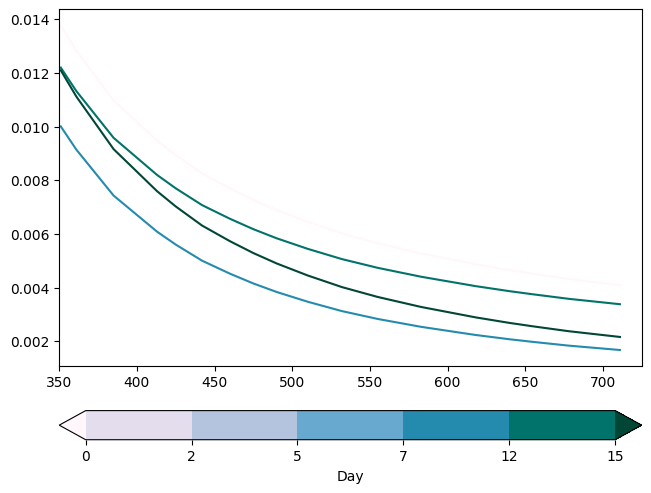

In [13]:
colors = pl.cm.PuBuGn(np.linspace(0,1,np.size(bb_paths[0:7])))

cmap = mpl.cm.PuBuGn
bounds = [0, 2, 5, 7, 12, 15]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

fig, ax = plt.subplots(layout='constrained')
for i in range(len(bb_paths[0:7])):
    plt.plot(provina_sub_mean["wavelength"].values,provina_sub_mean["bb"].values[i], color=colors[i], label='%s day' % i)
    plt.xlim([350,725])
    #plt.ylim([-0.001,0.011])


fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='horizontal',
             label="Day")

In [46]:
bb_paths = earthaccess.open(results2)

QUEUEING TASKS | :   0%|          | 0/213 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/213 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/213 [00:00<?, ?it/s]

In [47]:
## ChatGPT - for weekly

# Step 1: Group paths by ISO week (e.g. '2025-W09') for bb
paths_by_week_bb = defaultdict(list)

for path in bb_paths:
    match = re.search(r'(\d{8})', str(path))  # Match full date (YYYYMMDD)
    if match:
        date_str = match.group(1)
        date_obj = datetime.strptime(date_str, "%Y%m%d")
        week_id = f"{date_obj.isocalendar().year}-W{date_obj.isocalendar().week:02d}"
        paths_by_week_bb[week_id].append(path)

# Step 2: Load each group into a dataset with real dates for bb
datasets_by_week_bb = {}

for week_id, file_group in paths_by_week_bb.items():
    # Extract actual dates from filenames
    dates = [
        datetime.strptime(re.search(r'\d{8}', str(p)).group(), "%Y%m%d")
        for p in file_group
    ]

    # Sort files and dates together
    file_date_pairs = sorted(zip(dates, file_group))
    sorted_dates, sorted_paths = zip(*file_date_pairs)

    # Load the dataset and assign the correct dates
    ds_bb = xr.open_mfdataset(
        sorted_paths,
        combine="nested",
        concat_dim="date"
    ).assign_coords(date=("date", pd.to_datetime(sorted_dates)))
   
    ds_bb_sub = ds_bb.sel({"lon": slice(135.5, 138.6), "lat": slice(-32.7, -36)})
    ds_bb_sub_mean = ds_bb_sub.mean(dim=("date"), skipna=True).compute()
    datasets_by_week_bb[week_id] = ds_bb_sub_mean["bb"]

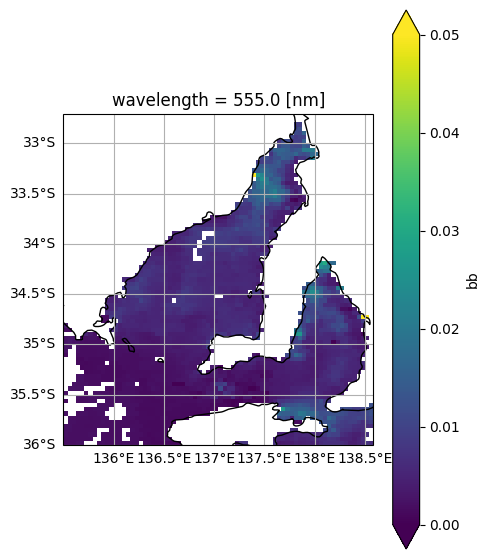

In [48]:
fig = plt.figure(figsize = (5,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = datasets_by_week_bb['2025-W18'].isel(wavelength=11).plot(x='lon', y='lat', cmap="viridis", vmin=0, vmax=.05)

In [ ]:
# 1. Weeks
weeks = [f"2025-W{str(i).zfill(2)}" for i in range(1, 32)]

# 2. Region
lat_slice = slice(-32.7, -36)
lon_slice = slice(135.6, 138.7)

# 3. Output folder
os.makedirs("gif_frames", exist_ok=True)
filenames = []

# 4. Fixed color scale (linear)
vmin = 0
vmax = 0.03

# 5. Loop through weeks
for week in weeks:
    if week not in datasets_by_week_bb:
        print(f"Skipping missing week: {week}")
        continue

    fig = plt.figure(figsize=(6, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([lon_slice.start, lon_slice.stop, lat_slice.start, lat_slice.stop], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines(draw_labels={"left": "y", "bottom": "x"})

    # 🌟 Plot a star for Adelaide
    ax.plot(
        138.6007, -34.9285,
        marker='*',
        color='b',
        markersize=12,
        transform=ccrs.PlateCarree(),
        label='Adelaide'
    )

    # Plot with fixed linear scale
    im = ax.pcolormesh(
        datasets_by_week_bb[week]["lon"],
        datasets_by_week_bb[week]["lat"],
        datasets_by_week_bb[week].isel(wavelength=11),
        cmap='jet',
        vmin=vmin,
        vmax=vmax,
        transform=ccrs.PlateCarree()
    )

    # Fixed-position colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.8, pad=0.05)
    cbar.set_label("Bb [m-1]")

    ax.set_title(f"Backscattering - Week {week}")

    # Save frame
    filename = f"gif_frames/frame_{week}.png"
    plt.savefig(filename, bbox_inches='tight', dpi=100)
    filenames.append(filename)
    plt.close()

# 6. Create the GIF
with imageio.get_writer('bb_weekly.gif', mode='I', duration=500, loop = 0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

print("GIF saved as 'bb_weekly.gif'")

### Absorption Coefficient

In [3]:
tspan = ("2025-01-01", "2025-08-04")

results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_IOP_NRT",
    granule_name="*.DAY.*a.4km.*",
    temporal=tspan
)

a_paths = earthaccess.open(results)
print(len(a_paths))

QUEUEING TASKS | :   0%|          | 0/214 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/214 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/214 [00:00<?, ?it/s]

214


In [4]:
## ChatGPT - for weekly

# Step 1: Group paths by ISO week (e.g. '2025-W09') for a
paths_by_week_a = defaultdict(list)

for path in a_paths:
    match = re.search(r'(\d{8})', str(path))  # Match full date (YYYYMMDD)
    if match:
        date_str = match.group(1)
        date_obj = datetime.strptime(date_str, "%Y%m%d")
        week_id = f"{date_obj.isocalendar().year}-W{date_obj.isocalendar().week:02d}"
        paths_by_week_a[week_id].append(path)

# Step 2: Load each group into a dataset with real dates for a
datasets_by_week_a = {}

for week_id, file_group in paths_by_week_a.items():
    # Extract actual dates from filenames
    dates = [
        datetime.strptime(re.search(r'\d{8}', str(p)).group(), "%Y%m%d")
        for p in file_group
    ]

    # Sort files and dates together
    file_date_pairs = sorted(zip(dates, file_group))
    sorted_dates, sorted_paths = zip(*file_date_pairs)

    # Load the dataset and assign the correct dates
    ds_a = xr.open_mfdataset(
        sorted_paths,
        combine="nested",
        concat_dim="date"
    ).assign_coords(date=("date", pd.to_datetime(sorted_dates)))
   
    ds_a_sub = ds_a.sel({"lon": slice(135.5, 138.6), "lat": slice(-32.7, -36)})
    ds_a_sub_mean = ds_a_sub.mean(dim=("date"), skipna=True).compute()
    datasets_by_week_a[week_id] = ds_a_sub_mean["a"]

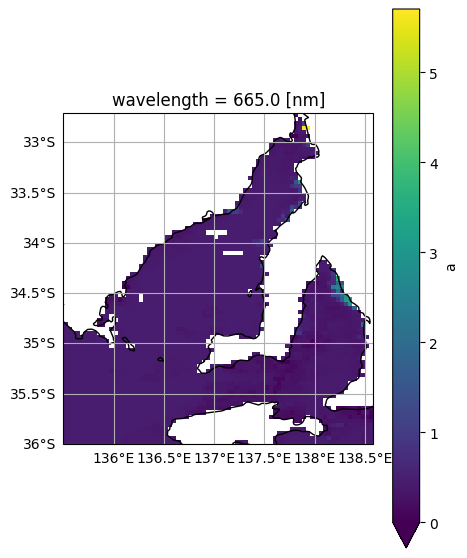

In [46]:
fig = plt.figure(figsize = (5,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = (datasets_by_week_a['2025-W22']).isel(wavelength=16).plot(x='lon', y='lat', cmap="viridis", vmin=0)

In [58]:
# 1. Weeks
weeks = [f"2025-W{str(i).zfill(2)}" for i in range(1, 32)]

# 2. Region
lat_slice = slice(-32.7, -36)
lon_slice = slice(135.6, 138.7)

# 3. Output folder
os.makedirs("gif_frames", exist_ok=True)
filenames = []

# 4. Fixed color scale (linear)
vmin = 0
vmax = 1 #change it

# 5. Loop through weeks
for week in weeks:
    if week not in datasets_by_week_a:
        print(f"Skipping missing week: {week}")
        continue

    fig = plt.figure(figsize=(6, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([lon_slice.start, lon_slice.stop, lat_slice.start, lat_slice.stop], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines(draw_labels={"left": "y", "bottom": "x"})

    # 🌟 Plot a star for Adelaide
    ax.plot(
        138.6007, -34.9285,
        marker='*',
        color='b',
        markersize=12,
        transform=ccrs.PlateCarree(),
        label='Adelaide'
    )

    # Plot with fixed linear scale
    im = ax.pcolormesh(
        datasets_by_week_a[week]["lon"],
        datasets_by_week_a[week]["lat"],
        datasets_by_week_a[week].isel(wavelength=16),
        cmap='jet',
        vmin=vmin,
        vmax=vmax,
        transform=ccrs.PlateCarree()
    )

    # Fixed-position colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.8, pad=0.05)
    cbar.set_label("a [m-1]")

    ax.set_title(f"Absorption - Week {week}")

    # Save frame
    filename = f"gif_frames/frame_{week}.png"
    plt.savefig(filename, bbox_inches='tight', dpi=100)
    filenames.append(filename)
    plt.close()

# 6. Create the GIF
with imageio.get_writer('a_weekly.gif', mode='I', duration=500, loop = 0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

print("GIF saved as 'a_weekly.gif'")

/tmp/ipykernel_8334/2833963387.py:64: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved as 'a_weekly.gif'
